多変量時系列(株価＋日経平均) + すべてのタイムステップで次の10個を予測
===

株価データに日経平均を追加した多変量時系列データを使い、全てのタイムステップで次のn日分の株価を予測する

試した学習モデル
- ベースライン指標となる線形モデル
- LSTM
- GRU
- 1次元CNN
- WaveNet
- 多層LSTM + Attention

In [7]:
! pip install Quandl

In [8]:
import quandl
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import keras
from pathlib import Path
import random
import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    #plt.hlines(0, 0, 100, linewidth=1)
    #plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    # plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

# 株価データを取得する

In [10]:

tse_codes = {
    'nikkei': 'CHRIS/CME_NK2',
    'toyota': 'TSE/7203',
    'canon': 'TSE/7751',
    'sony': 'TSE/6758',
}
dpath = Path('./data/')
if not dpath.exists():
    dpath.mkdir()

for name, code in tse_codes.items():
    print(f'Check {name}')
    fpath = dpath / Path(f'{name}.csv')
    if not fpath.exists():
        print('not found. start to download')
        df = quandl.get(code)
        df.to_csv(fpath)

Check nikkei
Check toyota
Check canon
Check sony


# Rawデータを見てみる

In [11]:
company_name = 'canon'
fpath_data = Path(f'./data/{company_name}.csv')
quandl_data = pd.read_csv(fpath_data)
stock = pd.read_csv(fpath_data)
stock

,Date,Open,High,Low,Close,Volume
0,2007-01-04,6740.0,6750.0,6650.0,6670.0,3115700.0
1,2007-01-05,6680.0,6720.0,6490.0,6530.0,4972700.0
2,2007-01-09,6540.0,6620.0,6520.0,6590.0,3413000.0
3,2007-01-10,6520.0,6560.0,6420.0,6460.0,4580700.0
4,2007-01-11,6450.0,6550.0,6410.0,6460.0,4101800.0
...,...,...,...,...,...,...
2685,2017-12-18,4350.0,4353.0,4327.0,4338.0,2764700.0
2686,2017-12-19,4350.0,4360.0,4342.0,4349.0,2555500.0
2687,2017-12-20,4350.0,4367.0,4346.0,4363.0,2798300.0
2688,2017-12-21,4360.0,4377.0,4349.0,4377.0,3507900.0


In [12]:
# DataFrameの列を一部変更して、移動平均などを追加
class ColumnOrganizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.iloc[:, 0] =  pd.to_datetime(X.iloc[:,0], format='%Y-%m-%d')
        X = X.set_index('Date')

        # 移動平均
        X['60MA'] = X['Close'].rolling(window = 100, min_periods=0).mean()
        X['180MA'] = X['Close'].rolling(window = 200, min_periods=0).mean()
        return X

col_organizer = ColumnOrganizer()
stock_modified = col_organizer.fit_transform(stock)

株価の過去データを描画

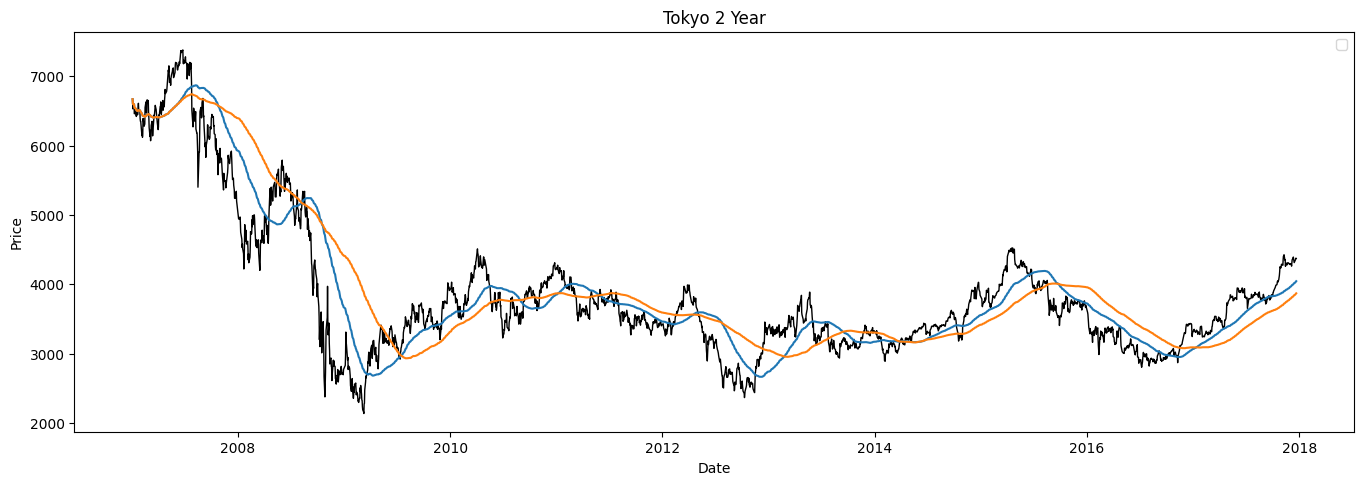

In [13]:
fig = plt.figure(figsize=(16, 5))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.plot(stock_modified['Close'][:], 'black', lw = 1)
axes.plot(stock_modified['60MA'][:])
axes.plot(stock_modified['180MA'][:])
axes.set_xlabel('Date')
axes.set_ylabel('Price')
axes.set_title('Tokyo 2 Year')
axes.legend()

plt.show()

# 日経平均株価と合わせて表示してみる

In [14]:
company_name = 'nikkei'
fpath_data = Path(f'./data/{company_name}.csv')
quandl_data = pd.read_csv(fpath_data)
df_nikkei = pd.read_csv(fpath_data)
df_nikkei

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,1990-09-26,23195.0,23195.0,23195.0,23195.0,NaN,23195.0,8.0,4.0
1,1990-09-27,22295.0,22305.0,22295.0,22305.0,NaN,22305.0,1.0,5.0
2,1990-09-28,21690.0,21690.0,21690.0,21690.0,NaN,21690.0,2.0,6.0
3,1990-10-01,21480.0,22160.0,21480.0,22160.0,NaN,22160.0,0.0,2.0
4,1990-10-02,23060.0,23060.0,23060.0,23060.0,NaN,23060.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...
7748,2021-06-23,NaN,28810.0,28570.0,28810.0,-45.0,28615.0,0.0,12.0
7749,2021-06-24,28995.0,28995.0,28995.0,28960.0,230.0,28845.0,2.0,12.0
7750,2021-06-25,NaN,28970.0,NaN,28970.0,30.0,28875.0,0.0,12.0
7751,2021-06-28,NaN,28925.0,28765.0,28925.0,-80.0,28795.0,0.0,12.0


In [15]:
# DataFrameの列を一部変更して、移動平均などを追加
class NikkeiColumnOrganizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.loc[:, 'Date'] =  pd.to_datetime(X.loc[:, 'Date'], format='%Y-%m-%d')
        X = X.set_index('Date')

        # 移動平均を追加
        X['Nikkei-60MA'] = X['Last'].rolling(window = 100, min_periods=0).mean()
        X['Nikkei-180MA'] = X['Last'].rolling(window = 200, min_periods=0).mean()

        # カラムのフィルター
        X = X.loc[:, ['Open', 'High', 'Low', 'Last', 'Volume', 'Previous Day Open Interest']]
        # カラムの名前変更
        X = X.rename({'Open':'NK-Open', 'High': 'NK-High', 'Low': 'NK-Low', 'Last': 'NK-Last',
                    'Volume': 'NK-Volume', 'Previous Day Open Interest': 'NK-Previous Day Open Interest'},
                     axis=1)
        return X
nk_col_organizer = NikkeiColumnOrganizer()
df_nikkei_modified = nk_col_organizer.fit_transform(df_nikkei)
df_nikkei_modified

,NK-Open,NK-High,NK-Low,NK-Last,NK-Volume,NK-Previous Day Open Interest
Date,,,,,,
1990-09-26,23195.0,23195.0,23195.0,23195.0,8.0,4.0
1990-09-27,22295.0,22305.0,22295.0,22305.0,1.0,5.0
1990-09-28,21690.0,21690.0,21690.0,21690.0,2.0,6.0
1990-10-01,21480.0,22160.0,21480.0,22160.0,0.0,2.0
1990-10-02,23060.0,23060.0,23060.0,23060.0,0.0,2.0
...,...,...,...,...,...,...
2021-06-23,NaN,28810.0,28570.0,28810.0,0.0,12.0
2021-06-24,28995.0,28995.0,28995.0,28960.0,2.0,12.0
2021-06-25,NaN,28970.0,NaN,28970.0,0.0,12.0


In [16]:
# 欠損値のチェック
df_nikkei_modified.isna().any()

NK-Open                           True
NK-High                           True
NK-Low                            True
NK-Last                           True
NK-Volume                        False
NK-Previous Day Open Interest    False
dtype: bool

In [17]:
pipeline = Pipeline([
    ('attribute_filter', NikkeiColumnOrganizer()),
    # ('imputer', SimpleImputer(strategy='median')), # 欠損値がある場合には、中央値で埋める
    # ('std_scaler', StandardScaler()),
    # ('series_maker', SeriesMaker(n_steps, n_predicts)),
])

df_nikkei_modified = pipeline.fit_transform(df_nikkei)
# print(f'np_nikkei_scaled    : {np_nikkei_scaled.shape}')
df_nikkei_modified

,NK-Open,NK-High,NK-Low,NK-Last,NK-Volume,NK-Previous Day Open Interest
Date,,,,,,
1990-09-26,23195.0,23195.0,23195.0,23195.0,8.0,4.0
1990-09-27,22295.0,22305.0,22295.0,22305.0,1.0,5.0
1990-09-28,21690.0,21690.0,21690.0,21690.0,2.0,6.0
1990-10-01,21480.0,22160.0,21480.0,22160.0,0.0,2.0
1990-10-02,23060.0,23060.0,23060.0,23060.0,0.0,2.0
...,...,...,...,...,...,...
2021-06-23,NaN,28810.0,28570.0,28810.0,0.0,12.0
2021-06-24,28995.0,28995.0,28995.0,28960.0,2.0,12.0
2021-06-25,NaN,28970.0,NaN,28970.0,0.0,12.0


銘柄株価に日経のカラムを連結する

In [18]:
stock_nikkei = pd.merge(stock_modified, df_nikkei_modified, left_index = True, right_index = True)
stock_nikkei

,Open,High,Low,Close,Volume,60MA,180MA,NK-Open,NK-High,NK-Low,NK-Last,NK-Volume,NK-Previous Day Open Interest
Date,,,,,,,,,,,,,
2007-01-04,6740.0,6750.0,6650.0,6670.0,3115700.0,6670.000000,6670.000000,17430.0,17430.0,17430.0,17430.0,0.0,0.0
2007-01-05,6680.0,6720.0,6490.0,6530.0,4972700.0,6600.000000,6600.000000,17150.0,17150.0,16945.0,16945.0,0.0,0.0
2007-01-09,6540.0,6620.0,6520.0,6590.0,3413000.0,6596.666667,6596.666667,17250.0,17250.0,17250.0,17250.0,0.0,0.0
2007-01-10,6520.0,6560.0,6420.0,6460.0,4580700.0,6562.500000,6562.500000,17000.0,17000.0,17000.0,17000.0,0.0,0.0
2007-01-11,6450.0,6550.0,6410.0,6460.0,4101800.0,6542.000000,6542.000000,17035.0,17035.0,17035.0,17035.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-18,4350.0,4353.0,4327.0,4338.0,2764700.0,4022.180000,3847.905000,NaN,22875.0,NaN,22875.0,0.0,0.0
2017-12-19,4350.0,4360.0,4342.0,4349.0,2555500.0,4027.590000,3853.245000,NaN,NaN,22755.0,22755.0,0.0,0.0
2017-12-20,4350.0,4367.0,4346.0,4363.0,2798300.0,4033.090000,3858.600000,NaN,22805.0,NaN,22790.0,0.0,0.0


株価と日経平均を合わせて表示

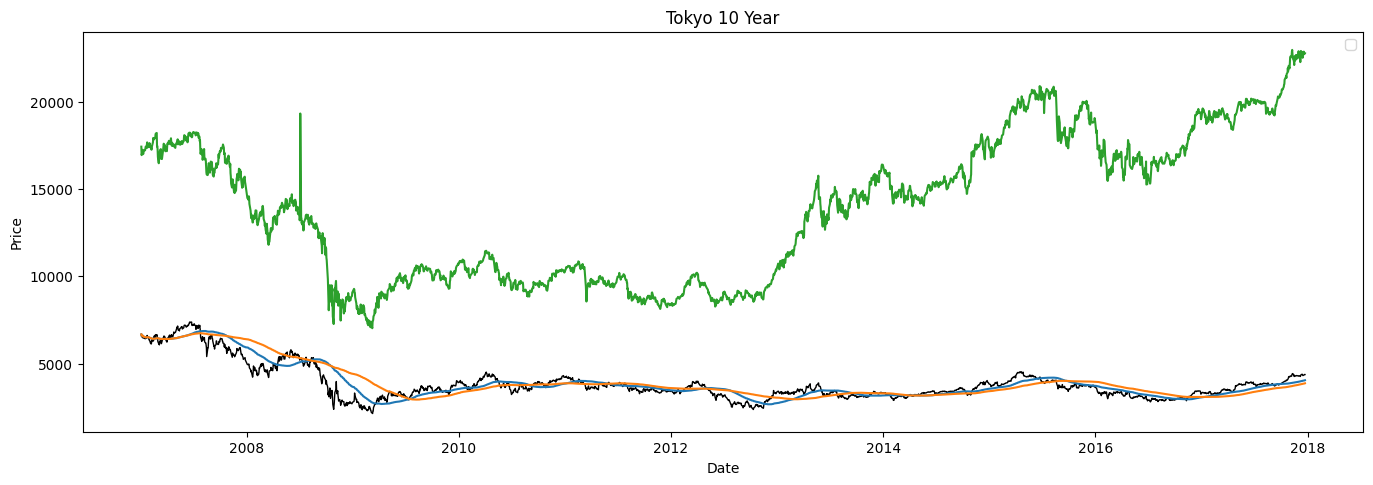

In [19]:
fig = plt.figure(figsize=(16, 5))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.plot(stock_nikkei['Close'][:], 'black', lw = 1)
axes.plot(stock_nikkei['60MA'][:])
axes.plot(stock_nikkei['180MA'][:])
axes.plot(stock_nikkei['NK-Last'][:])
axes.set_xlabel('Date')
axes.set_ylabel('Price')
axes.set_title('Tokyo 10 Year')
axes.legend()

plt.show()

# データパイプライン

In [20]:
# 訓練データに必要な列だけ残す
class ColumnFilter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_filtered = X.loc[:, ['Close', 'Open', 'High', 'Low', 'Volume', # 注意: 予測対象を1列目に設定する
                               # 'NK-Open', 'NK-High', 'NK-Low', 'NK-Volume',
                               'NK-Last']
        ]
        return X_filtered

col_filter = ColumnFilter()
col_filter.fit_transform(stock_nikkei)

,Close,Open,High,Low,Volume,NK-Last
Date,,,,,,
2007-01-04,6670.0,6740.0,6750.0,6650.0,3115700.0,17430.0
2007-01-05,6530.0,6680.0,6720.0,6490.0,4972700.0,16945.0
2007-01-09,6590.0,6540.0,6620.0,6520.0,3413000.0,17250.0
2007-01-10,6460.0,6520.0,6560.0,6420.0,4580700.0,17000.0
2007-01-11,6460.0,6450.0,6550.0,6410.0,4101800.0,17035.0
...,...,...,...,...,...,...
2017-12-18,4338.0,4350.0,4353.0,4327.0,2764700.0,22875.0
2017-12-19,4349.0,4350.0,4360.0,4342.0,2555500.0,22755.0
2017-12-20,4363.0,4350.0,4367.0,4346.0,2798300.0,22790.0


In [21]:
n_steps = 50 # 入力ステップ数
n_predicts = 7 # 予測日数

# １つずつずらした時系列データを作る
class SeriesMaker(BaseEstimator, TransformerMixin):
    def __init__(self, n_steps, n_predicts):
        self.n_steps = n_steps
        self.n_predicts = n_predicts

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        series = []
        for i in range(0, len(X) - self.n_steps - self.n_predicts):
            d = X[i : i + self.n_steps + self.n_predicts]
            series.append(d)
        X_series = np.array(series)
        # np.random.shuffle(X_series)
        return X_series

# series_maker = SeriesMaker(n_steps, n_predicts)
# series_maker.fit_transform(stock).shape

In [22]:
n_test = 720 # 何日前からのデータをテストデータにするか

stock_train = stock_nikkei.iloc[:-n_test, :]
stock_valid = stock_nikkei.iloc[-n_test:, :]
print(f'stock train: {stock_train.shape}')
print(f'stock valid : {stock_valid.shape}')

pipeline = Pipeline([
    ('attribute_filter', ColumnFilter()),
    ('imputer', SimpleImputer(strategy='median')), # 欠損値がある場合には、中央値で埋める
    ('std_scaler', StandardScaler()),
    ('series_maker', SeriesMaker(n_steps, n_predicts)), # シリーズ化は最後
])

X_train = pipeline.fit_transform(stock_train)
print(f'X_train    : {X_train.shape}')

# Accessing the mean and variance of the StandardScaler step
scaler = pipeline.named_steps['std_scaler']
print(f'平均値: {scaler.mean_}')
print(f'標準偏差 {np.sqrt(scaler.var_)}')

stock train: (1885, 13)
stock valid : (720, 13)
X_train    : (1828, 57, 6)
平均値: [3.91962175e+03 3.92131565e+03 3.96151645e+03 3.88059416e+03
 5.70509215e+06 1.20139310e+04]
標準偏差 [1.12880183e+03 1.12889369e+03 1.13800074e+03 1.12033697e+03
 2.84475498e+06 3.07559587e+03]


In [23]:
# stock_validはまだimputeしてないので欠損値を含む
stock_valid.isna().any()

Open                             False
High                             False
Low                              False
Close                            False
Volume                           False
60MA                             False
180MA                            False
NK-Open                           True
NK-High                           True
NK-Low                            True
NK-Last                           True
NK-Volume                        False
NK-Previous Day Open Interest    False
dtype: bool

In [24]:
# 訓練データのStandardScalerの平均と標準偏差を使って変換だけ行う
class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, mean_, scale_):
        self.mean_ = mean_
        self.scale_ = scale_
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return (X - self.mean_) / self.scale_

pipeline = Pipeline([
    ('attribute_filter', ColumnFilter()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', MyStandardScaler(scaler.mean_, scaler.scale_)),
    ('series_maker', SeriesMaker(n_steps, n_predicts)), # シリーズ化は最後
])

X_valid = pipeline.fit_transform(stock_valid)
print(f'X_valid    : {X_valid.shape}')
# X_valid

X_valid    : (663, 57, 6)


In [25]:
X_valid[:, :, :].mean(axis=(0,1))

array([-0.30427056, -0.30439284, -0.31710682, -0.29301627, -0.56104804,
        2.15806328])

- 最後のタイムステップで次の10個を予測するのではなく、すべてのタイムステップで次の10個を予測する。
- シーケンス-to-ベクトル → シーケンス-to-シーケンスに変える

データセットの作り方のイメージ

１つのseries: [1, 2, 3, 4, 5, 6, 7, ..., 55, 56, 57, 58, 59, 60]

から以下10個を作る

- [1, 2, 3, 4, 5, 6, 7, ..., 47, 48, 49, 50]
- [2, 3, 4, 5, 6, 7, 8, ..., 48, 49, 50, 51]
- [3, 4, 5, 6, 7, 8, 9, ..., 49, 50, 51, 52]
- ...
- [10, 11, 12, 13, 14, 15, ..., 57, 58, 59, 60]

In [26]:
# 訓練、テストデータの作成
Y_train = np.empty((X_train.shape[0], n_steps, n_predicts))
print(f'{Y_train.shape=}')
for step_ahead in range(1, n_predicts + 1):
    Y_train[..., step_ahead - 1] = X_train[..., step_ahead: step_ahead + n_steps, 0] # 注意: 3次元目のうち第1要素が株価
X_train = X_train[:, :-n_predicts]
print(X_train.shape)

Y_valid = np.empty((X_valid.shape[0], n_steps, n_predicts))
print(f'{Y_valid.shape=}')
for step_ahead in range(1, n_predicts + 1):
    Y_valid[..., step_ahead - 1] = X_valid[..., step_ahead: step_ahead + n_steps, 0] # 注意: 3次元目のうち第1要素が株価
X_valid = X_valid[:, :-n_predicts]

# 訓練、検証データに分割
# from sklearn.model_selection import train_test_split
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
# print(X_test.shape, Y_test.shape)

Y_train.shape=(1828, 50, 7)
(1828, 50, 6)
Y_valid.shape=(663, 50, 7)
(1828, 50, 6) (1828, 50, 7)
(663, 50, 6) (663, 50, 7)


In [27]:
# カスタム評価が必要
def last_time_step_mse(Y_true, Y_pred):
    # return np.mean((Y_true[:, -1] - Y_pred[:, -1]) ** 2) # エラー: numpy配列ではなくテンソルを返す必要がある
    print(Y_true)
    print(Y_pred)
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

# モデルの予測結果をレビューする関数

In [28]:
def plot_multiple_forecat():
    Y_pred = model.predict(X_valid)
    print(X_valid.shape, Y_pred.shape) # (295, 60, 5) (295, 60, 7)

    rmse = mean_squared_error(Y_pred[:, -1, :], Y_valid[:, -1, :], squared=False)
    rmse_stock = rmse  * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
    print(f'rmse: {rmse_stock}')

    idx = random.randrange(0, X_valid.shape[0])
    x_valid = X_valid[idx, :, 0] # Closed列のステップ数分の過去データ
    x_valid.shape # (30,)

    y_pred = Y_pred[idx, -1]
    y_pred.shape # (5,)

    y_valid = Y_valid[idx, -1]
    y_valid

    plt.figure(figsize=(14, 5))
    plt.plot(np.arange(0, n_steps), x_valid * scaler.scale_[0] + scaler.mean_[0])
    plt.plot(np.arange(n_steps, n_steps + n_predicts), y_valid * scaler.scale_[0] + scaler.mean_[0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + n_predicts), y_pred * scaler.scale_[0] + scaler.mean_[0], "rx-", label="Forecast", markersize=10)
    plt.legend(fontsize=14)
    plt.grid(True)

# 学習曲線のチェック

In [29]:
# loss, accuracy の履歴をプロット
def plot_fit_history():
    df = pd.DataFrame(history.history)
    df.plot(figsize=(14, 5))
    plt.grid(True)
    plt.ylim((0))
    plt.show()

# ベースライン指標（単純に最後の値を予測数分コピーする）

In [30]:
Y_valid.shape

(663, 50, 7)

In [31]:
# X_validの平均値を予測値とした場合
Y_pred = np.empty(Y_valid.shape)
Y_pred[...] = X_valid.mean()
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.2764333938913126

In [32]:
# X_validの最後のタイムステップの値を予測値とした場合
Y_pred = np.empty(Y_valid.shape)
for y in range(n_steps):
    for z in range(n_predicts):
        Y_pred[:, y, z] = X_valid[:, y, 0]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.006736810968743284

# ベースライン指標（線型回帰モデル）

In [62]:
%%time
n_epochs = 1000
n_patience = 10

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(n_steps, 6)),
    keras.layers.Dense(n_steps * n_predicts),
    keras.layers.Reshape(target_shape=(n_steps, n_predicts)),
])
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
model.summary()

# logging
model_id = f'linear-multivar-steps{n_steps}-pred{n_predicts}'
dpath_logs = f"./logs/fit-pred7/{model_id}-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./checkpoint/{model_id}.keras', verbose=1,
                                                save_best_only=True,
)

# early stopping
early_stop_cb = keras.callbacks.EarlyStopping(patience=n_patience, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, early_stop_cb, tboard_cb]
                   )
model.evaluate(X_valid, Y_valid)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 300)               0         
                                                                 
 dense_9 (Dense)             (None, 350)               105350    
                                                                 
 reshape_1 (Reshape)         (None, 50, 7)             0         
                                                                 
Total params: 105350 (411.52 KB)
Trainable params: 105350 (411.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
Tensor("IteratorGetNext:1", shape=(None, 50, 7), dtype=float32)
Tensor("sequential_1/reshape_1/Reshape:0", shape=(None, 50, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 50, 7), dtype=float32)
Tensor("sequential_1/reshape_1/Reshape:0", shape=(None, 50

[0.0015197994653135538, 0.011003537103533745]

21/21 [==============================] - 0s 2ms/step
(663, 50, 6) (663, 50, 7)
rmse: 4033.659175765152


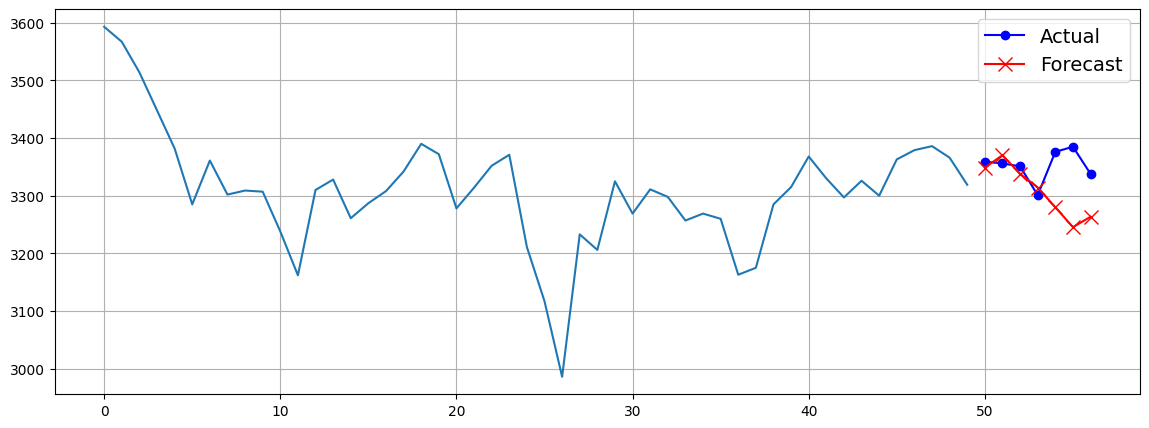

In [68]:
plot_multiple_forecat()

# LSTMの場合

In [ ]:
%%time
n_neuron = 20
# learning_rate = 0.0005
learning_rate = 0.0002
n_epochs = 1000
n_patience = 10

model = keras.models.Sequential([
    keras.layers.LSTM(n_neuron, return_sequences=True, input_shape=[None, X_train.shape[-1]]),
    keras.layers.LSTM(n_neuron, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_predicts))
])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[last_time_step_mse])
model.summary()

# logging
model_id = f'lstm-multivar-steps{n_steps}-pred{n_predicts}-depth2-neuron{n_neuron}-lr{learning_rate}'
dpath_logs = f"./logs/fit-pred7/{model_id}-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./checkpoint/{model_id}.keras', verbose=1,
                                                save_best_only=True,
)

# early stopping
early_stop_cb = keras.callbacks.EarlyStopping(patience=n_patience, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, early_stop_cb, tboard_cb]
                   )
model.evaluate(X_valid, Y_valid)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          2160      
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          3280      
                                                                 
 time_distributed (TimeDist  (None, None, 7)           147       
 ributed)                                                        
                                                                 
Total params: 5587 (21.82 KB)
Trainable params: 5587 (21.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
Tensor("IteratorGetNext:1", shape=(None, 50, 7), dtype=float32)
Tensor("sequential_2/time_distributed/Reshape_1:0", shape=(None, 50, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 50, 7), dtyp

[0.015384090133011341, 0.013569239526987076]

21/21 [==============================] - 0s 13ms/step
(663, 50, 6) (663, 50, 7)
rmse: 4049.215427202315


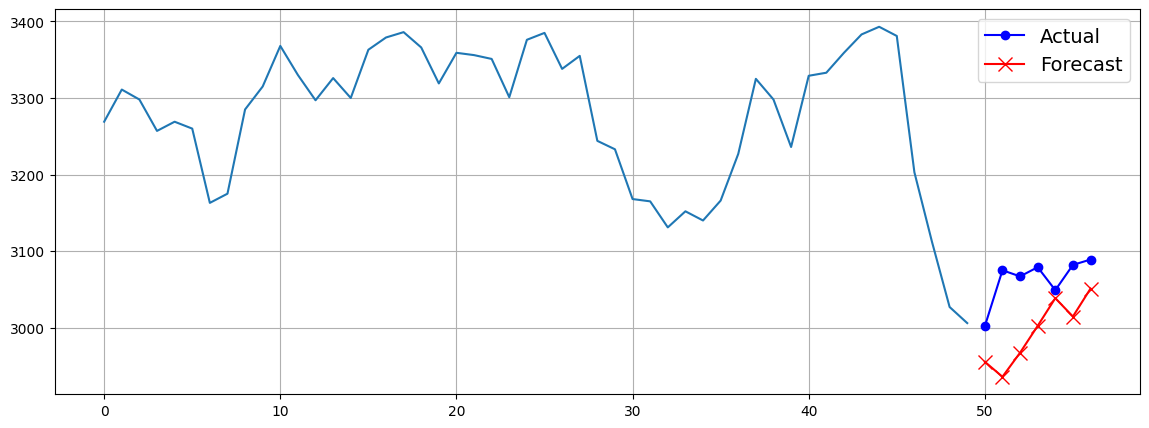

In [ ]:
# 予測結果を見てみる
plot_multiple_forecat()

# GRU

In [ ]:
%%time
n_neuron = 20
# learning_rate = 0.001
learning_rate = 0.001
n_epochs = 1000
n_patience = 10

model = keras.models.Sequential([
    keras.layers.GRU(n_neuron, return_sequences=True, input_shape=(None, X_train.shape[-1])),
    keras.layers.GRU(n_neuron, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_predicts))
])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[last_time_step_mse])
model.summary()

# logging
model_id = f'gru-multivar-steps{n_steps}-pred{n_predicts}-depth2-neuron{n_neuron}-lr{learning_rate}'
dpath_logs = f"./logs/fit-pred7/{model_id}-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./checkpoint/{model_id}.keras', verbose=1,
                                                save_best_only=True,
)

# early stopping
early_stop_cb = keras.callbacks.EarlyStopping(patience=n_patience, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, early_stop_cb, tboard_cb]
                   )
model.evaluate(X_valid, Y_valid)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1680      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed_1 (TimeDi  (None, None, 7)           147       
 stributed)                                                      
                                                                 
Total params: 4347 (16.98 KB)
Trainable params: 4347 (16.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
Tensor("IteratorGetNext:1", shape=(None, 50, 7), dtype=float32)
Tensor("sequential_3/time_distributed_1/Reshape_1:0", shape=(None, 50, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 50, 7), dt

[0.017723344266414642, 0.015784621238708496]

21/21 [==============================] - 0s 13ms/step
(663, 50, 6) (663, 50, 7)
rmse: 4058.915439682953


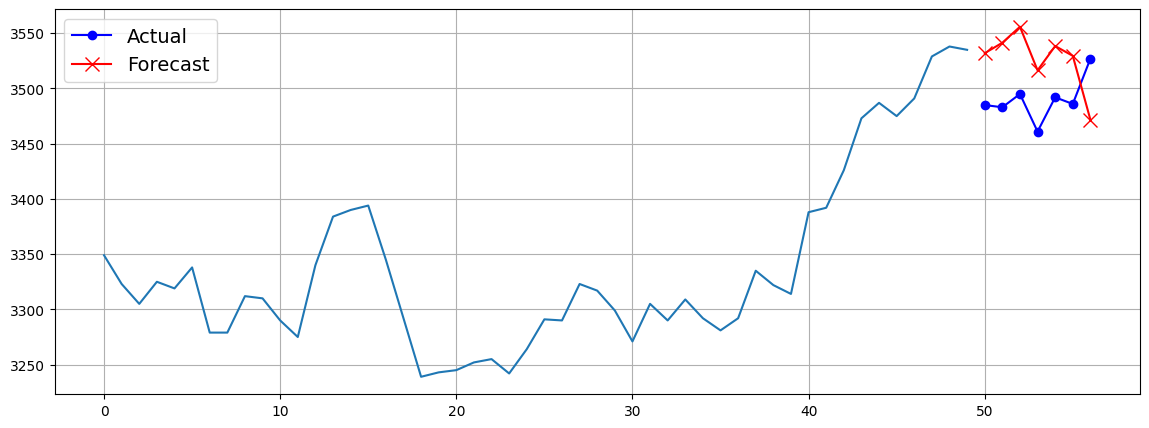

In [ ]:
plot_multiple_forecat()

# １次元CNNを使った版

In [ ]:
%%time
n_neuron = 20 # 150
learning_rate = 0.001
# learning_rate = 0.00075
# learning_rate = 0.0001
n_epochs = 1000
n_patience = 10


model = keras.models.Sequential([
    keras.layers.Conv1D(filters=n_neuron, kernel_size=4, strides=2, padding='valid',
                        input_shape=(None, X_train.shape[-1])),
    keras.layers.GRU(n_neuron, return_sequences=True),
    keras.layers.GRU(n_neuron, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_predicts))
])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[last_time_step_mse])
model.summary()

dpath_logs = "./logs/fit-pred7/cnn1d-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# logging
model_id = f'cnn1d-steps{n_steps}-pred{n_predicts}-neuron{n_neuron}-lr{learning_rate}'
dpath_logs = f"./logs/fit-pred7/{model_id}-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./checkpoint/{model_id}.keras', verbose=1,
                                                save_best_only=True,
)

# early stopping
early_stop_cb = keras.callbacks.EarlyStopping(patience=n_patience, restore_best_weights=True)


history = model.fit(X_train, Y_train[:, 3::2], epochs=50, validation_data=(X_valid, Y_valid[:, 3::2]),
                    callbacks=[checkpoint_cb, early_stop_cb, tboard_cb])
model.evaluate(X_valid, Y_valid[:, 3::2])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          500       
                                                                 
 gru_2 (GRU)                 (None, None, 20)          2520      
                                                                 
 gru_3 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 7)           147       
 stributed)                                                      
                                                                 
Total params: 5687 (22.21 KB)
Trainable params: 5687 (22.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
Tensor("IteratorGetNext:1", shape=(None, 24, 7), dtype=float32)
Tensor("seq

[0.020735839381814003, 0.022403940558433533]

21/21 [==============================] - 1s 7ms/step
(663, 50, 6) (663, 24, 7)
rmse: 4085.666480883488


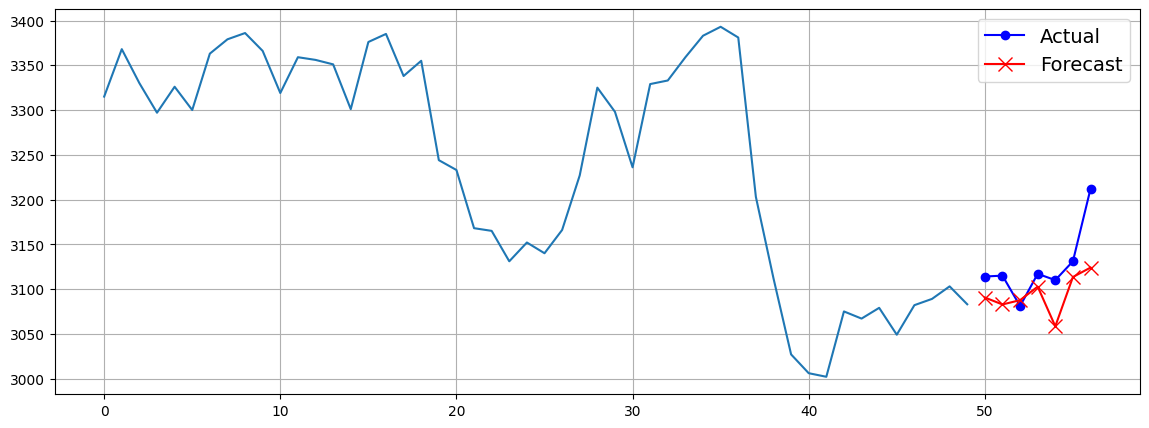

In [ ]:
plot_multiple_forecat()

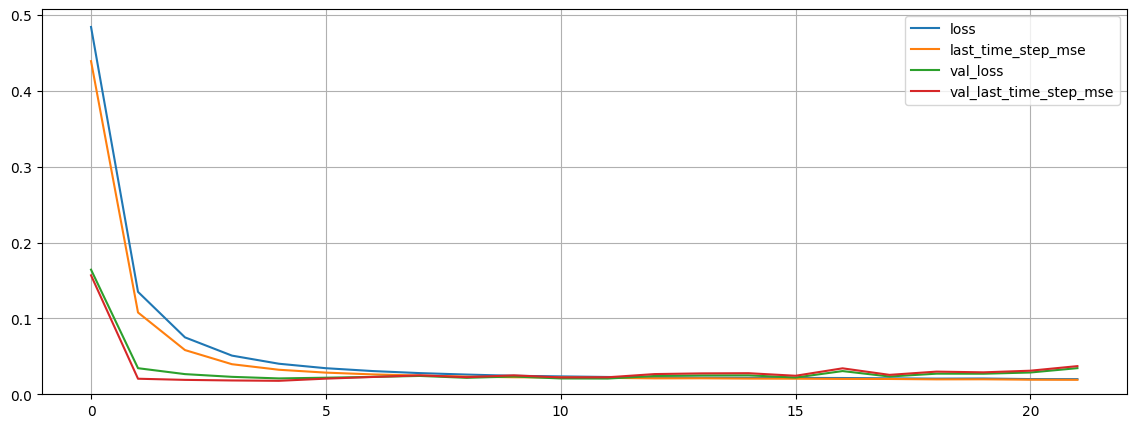

In [ ]:
plot_fit_history()

# WaveNet

In [ ]:
%%time
n_filters = 20 # 150
# learning_rate = 0.001
# learning_rate = 0.00075
# learning_rate = 0.0001
learning_rate = 0.00003
n_epochs = 1000
n_patience = 10

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, X_train.shape[-1]]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=n_filters, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=n_predicts, kernel_size=1))
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[last_time_step_mse])
model.summary()

# logging
model_id = f'wavenet-multivar-steps{n_steps}-pred{n_predicts}-block2-f{n_filters}-lr{learning_rate}'
dpath_logs = f"./logs/fit-pred7/{model_id}-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./checkpoint/{model_id}.keras', verbose=1,
                                                save_best_only=True,
)

# early stopping
early_stop_cb = keras.callbacks.EarlyStopping(patience=n_patience, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, early_stop_cb, tboard_cb]
                   )
model.evaluate(X_valid, Y_valid)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          260       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          820       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 20)          820       
                                                                 
 conv1d_3 (Conv1D)           (None, None, 20)          820       
                                                                 
 conv1d_4 (Conv1D)           (None, None, 20)          820       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 20)          820       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 20)          8

[0.03445754200220108, 0.03271003067493439]

21/21 [==============================] - 0s 5ms/step
(663, 50, 6) (663, 50, 7)
rmse: 4122.213538904897


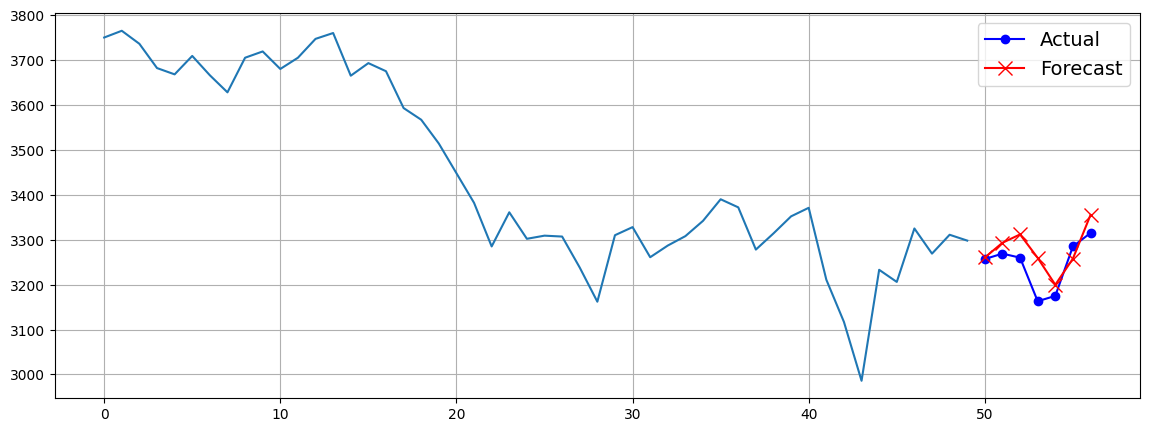

In [ ]:
plot_multiple_forecat()

# Attention

In [33]:
%%time
n_neuron = 30 # 30
# learning_rate = 0.0005
learning_rate = 0.002 # 0.002
n_epochs = 1000
n_patience = 10

# Define the model with attention
inputs = keras.Input(shape=[None, X_train.shape[-1]])
x = keras.layers.LSTM(n_neuron, return_sequences=True)(inputs)
x = keras.layers.LSTM(n_neuron, return_sequences=True)(x)
attention_output = keras.layers.Attention()([x, x])
outputs = keras.layers.TimeDistributed(keras.layers.Dense(n_predicts))(attention_output)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[last_time_step_mse])
model.summary()

# logging
model_id = f'attention-multivar-steps{n_steps}-pred{n_predicts}-depth2-neuron{n_neuron}-lr{learning_rate}'
dpath_logs = f"./logs/fit-pred7/{model_id}-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./checkpoint/{model_id}.keras', verbose=1,
                                                save_best_only=True,
)

# early stopping
early_stop_cb = keras.callbacks.EarlyStopping(patience=n_patience, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, early_stop_cb, tboard_cb]
                   )
model.evaluate(X_valid, Y_valid)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 6)]            0         []                            
                                                                                                  
 lstm (LSTM)                 (None, None, 30)             4440      ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, None, 30)             7320      ['lstm[0][0]']                
                                                                                                  
 attention (Attention)       (None, None, 30)             0         ['lstm_1[0][0]',              
                                                                     'lstm_1[0][0]']          

[0.010806025005877018, 0.01629585027694702]

In [34]:
%%time
n_neuron = 30 # 30
# learning_rate = 0.0005
learning_rate = 0.002 # 0.002
n_epochs = 1000
n_patience = 10

# Define the model with attention
inputs = keras.Input(shape=[None, X_train.shape[-1]])
x = keras.layers.LSTM(n_neuron, return_sequences=True)(inputs)
x = keras.layers.LSTM(n_neuron*2, return_sequences=True)(x)
x = keras.layers.LSTM(n_neuron*4, return_sequences=True)(x)
x = keras.layers.LSTM(n_neuron*8, return_sequences=True)(x)
attention_output = keras.layers.Attention()([x, x])
outputs = keras.layers.TimeDistributed(keras.layers.Dense(n_predicts))(attention_output)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[last_time_step_mse])
model.summary()

# logging
model_id = f'attention-multivar-steps{n_steps}-pred{n_predicts}-depth2-neuron{n_neuron}-lr{learning_rate}'
dpath_logs = f"./logs/fit-pred7/{model_id}-" + datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
tboard_cb = keras.callbacks.TensorBoard(log_dir=dpath_logs, histogram_freq=1)

# checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./checkpoint/{model_id}.keras', verbose=1,
                                                save_best_only=True,
)

# early stopping
early_stop_cb = keras.callbacks.EarlyStopping(patience=n_patience, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, early_stop_cb, tboard_cb]
                   )
model.evaluate(X_valid, Y_valid)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 6)]            0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, None, 30)             4440      ['input_2[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               (None, None, 60)             21840     ['lstm_2[0][0]']              
                                                                                                  
 lstm_4 (LSTM)               (None, None, 120)            86880     ['lstm_3[0][0]']              
                                                                                            

[0.002716889139264822, 0.009258190169930458]

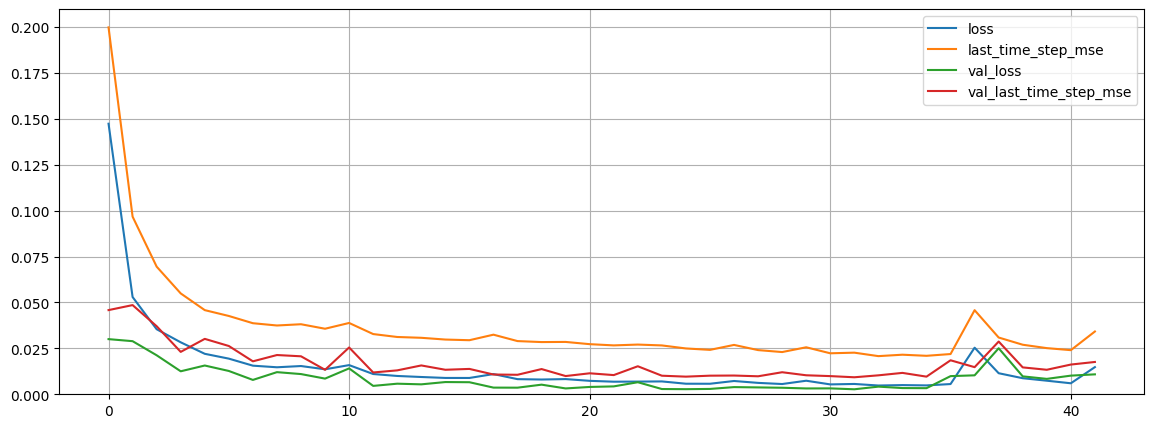

In [35]:
plot_fit_history()

21/21 [==============================] - 2s 81ms/step
(663, 50, 6) (663, 50, 7)
rmse: 4026.9396038953146


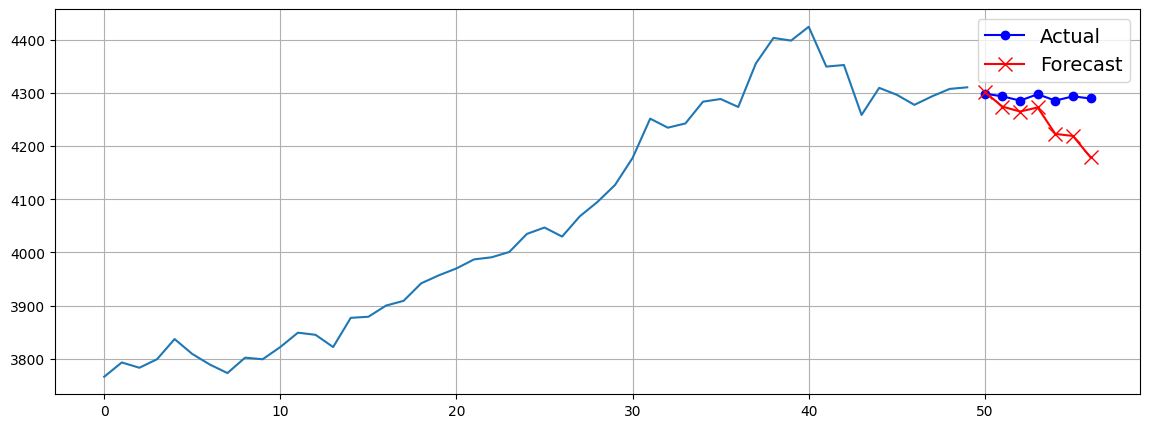

In [48]:
plot_multiple_forecat()

# テンソルボードの起動

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

# 学習済みモデルの読み込み

In [ ]:
# fpath_model = 'models/wavenet-f200-lr0.0001.keras'
#fpath_model = 'checkpoint/wavenet-multivar-steps60-pred7-block2-f20-lr0.0001.keras'
# fpath_model = 'checkpoint/lstm-multivar-steps50-pred7-depth2-neuron20-lr0.0005.keras'
fpath_model = 'checkpoint/lstm-multivar-steps50-pred7-depth2-neuron20-lr0.0005.keras'
#fpath_model = 'checkpoint/cnn1d-steps60-pred7-neuron20-lr0.0001.keras'
#fpath_model = 'checkpoint/gru-multivar-steps60-pred7-depth3-neuron20-lr0.001.keras'

model = keras.models.load_model(fpath_model, custom_objects={'last_time_step_mse': last_time_step_mse})
model.summary()
print('evaluate: ', model.evaluate(X_valid, Y_valid))
# print('evaluate: ', model.evaluate(X_valid, Y_valid[:, 3::2]))

Y_pred = model.predict(X_valid)
print(f'Y_pred.shape =', Y_pred.shape)

rmse = mean_squared_error(Y_pred[:, -1, :], Y_valid[:, -1, :], squared=False)
rmse_stock = rmse  * scaler.scale_[0] + scaler.mean_[0]
print(f'rmse stock: {rmse_stock}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, None, 20)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, None, 20)       │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 7)        │           147 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,523 (64.55 KB)

 Trainable params: 5,507 (21.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,016 (43.04 KB)

Tensor("IteratorGetNext:1", shape=(None, 50, 7), dtype=float32)
Tensor("sequential_4_1/time_distributed_3_1/transpose_1:0", shape=(None, 50, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 50, 7), dtype=float32)
Tensor("sequential_4_1/time_distributed_3_1/transpose_1:0", shape=(None, 50, 7), dtype=float32)
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - last_time_step_mse: 0.0222 - loss: 0.0237
evaluate:  [0.020389290526509285, 0.020945129916071892]
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Y_pred.shape = (663, 50, 7)
rmse stock: 4845.47223868883


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
